# Modelling

## Loading the data

In [33]:
import pandas as pd, numpy as np
import geopandas as gpd

# Polygons of blocks in New York.
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

#socioeconomic data
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)

#number of pickups per block
pickup_counts = pd.read_csv("./pickup_counts.csv", index_col = 0)

Now we will forecast the number of pickups happenning in a block throughout the three months given its socioeconomic factors.

First we build a pivot table from the acs data.

In [7]:
block_acs = acs.pivot(index = "geoid", columns = "acs_demog_var" ).droplevel(level = 0, axis = 1)
pct_nan = block_acs.isna().sum()/6339*100 #percentage of nan

Listed below are the features which have missing values (see percentage).

We will drop ```aggregate_travel_time_to_work``` and ```owner_occupied_housing_units_median_value``` since they have  94% and 28%. But regarding the rest of the features with missing values we will try to input data from surrounding blocks

In [8]:
pct_nan[pct_nan > 0]

acs_demog_var
aggregate_travel_time_to_work                                  94.289320
income_per_capita                                               1.151601
median_age                                                      1.056949
median_income                                                   7.335542
median_rent                                                     8.834201
median_year_structure_built                                     1.577536
owner_occupied_housing_units_median_value                      28.127465
renter_occupied_housing_units_paying_cash_median_gross_rent     8.392491
dtype: float64

## Inputting missing data from neighbor blocks
We could input each feature's median or the average value on Nans, but we can do better if we just take the values of the neighbor blocks, which will more likely be similar to the current missing one. To find each blocks´s neighbors we just slightly scale up all the block polygons and find which ones intersect.

In [9]:
nymap_scaled = nymap.copy()
nymap_scaled["geometry"] = nymap_scaled["geometry"].scale(xfact = 1.2,yfact = 1.2, origin = "center")


In [163]:
#took a while to compute this. Does not scale.
neigbors_df  = pd.DataFrame(index = nymap_scaled["geoid"], columns = nymap_scaled["geoid"])
from itertools import combinations
for x,y in combinations(nymap_scaled.values, 2):
    x_geoid, x_polygon = x
    y_geoid, y_polygon = y
    is_neighbor = x_polygon.intersects(y_polygon)
    neigbors_df.loc[x_geoid][y_geoid] = is_neighbor
    neigbors_df.loc[y_geoid][x_geoid] = is_neighbor

# We fill the Nan in the diagonal with False (intersection of block with itself) to avoid problems
neigbors_df.fillna(False, inplace = True) 

In [12]:
#neigbors_df.to_csv("neighbor_blocks_1.2.csv")
neigbors_df = pd.read_csv("./neighbor_blocks_1.2.csv", index_col=0)

In [18]:
def input_from_neighbors(df, columns_to_input, neighbor_matrix):
    data = df.copy()
    for column_name in columns_to_input:
        #We find which rows are misisng values 
        rows_missing_values = data[data[column_name].isna()].index
        for geoid in rows_missing_values:
            neighbors = neighbor_matrix[str(geoid)] #we search for neighbors of geoid
            mean_value_neighbors = data[column_name][neighbors].mean() #we compute here the mean of neighbors
            data.loc[geoid][column_name] = mean_value_neighbors
    return data


In [24]:
columns_to_input = ["income_per_capita","median_age", "median_income","median_rent", "median_year_structure_built", "renter_occupied_housing_units_paying_cash_median_gross_rent"]
block_acs = input_from_neighbors(block_acs, columns_to_input , neigbors_df)

In [25]:
# Drops features and checks that no longer are there missing values
block_acs.drop(["aggregate_travel_time_to_work", "owner_occupied_housing_units_median_value"], axis = 1, inplace = True)
block_acs.isna().sum().sum()

0

In [34]:
model_data = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True )
model_data.rename(columns = {"count" : "target"}, inplace = True)

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

In [240]:
#cor["target"].sort_values(ascending = False)

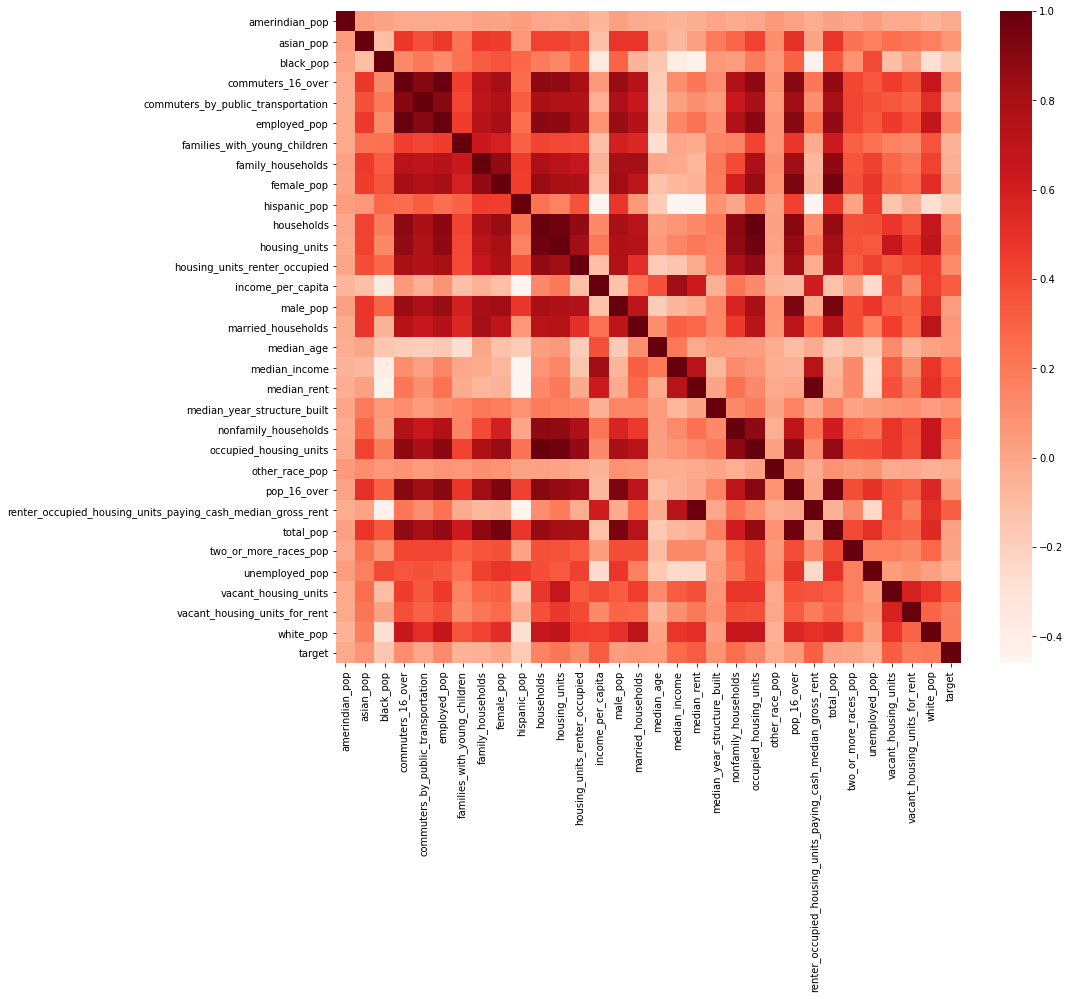

In [38]:
plt.figure(figsize=(14,12))
cor = model_data.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [85]:
import statsmodels

## Removing Outliers

In [ ]:
import stats
